# Financial Applications: CAPM

In [11]:
import yfinance as yf
import pandas as pd 
import matplotlib.pyplot as plt 

Importing Stock Data from Yahoo Finance 

In [12]:
def Data(Ticker, Sdate, Edate):
    tick = yf.Ticker(Ticker)
    hist_data =  tick.history(start = Sdate, end = Edate)
    hist_data['Volume'] = hist_data['Volume']/1e5
    hist_data['Returns'] = hist_data['Close'].pct_change()
    hist_data = hist_data[hist_data['Returns'].notna()]
    hist_data.reset_index(inplace = True)
    hist_data.rename(columns = {'index':'Date'}, inplace = True)
    hist_data['Date'] = hist_data['Date'].dt.strftime('%Y/%m/%d')
    hist_data['Date'] = pd.to_datetime(hist_data['Date']) 
    return hist_data

Collecting Data for CAPM (single stock)

In [13]:
MSFT_Tick = 'MSFT'
Market_Tick = '^GSPC' #Market Proxy: S&P 500 
Risk_Free_Tick = '^IRX' #3-month T-bills
SDate = '2022-11-01'
EDate = '2023-12-31'

MSFT = Data(MSFT_Tick, SDate, EDate)
MSFT = MSFT[['Date', 'Close', 'Returns']]
MSFT.rename(columns = {'Close':'MSFT_Price', 'Returns': 'MSFT_Returns'}, inplace = True)

Market = Data(Market_Tick, SDate, EDate)
Market = Market[['Close', 'Returns']]
Market.rename(columns = {'Close':'Market_Price', 'Returns': 'Market_Returns'}, inplace = True)

TBills =  Data(Risk_Free_Tick , SDate, EDate)
TBills['Rate'] = TBills['Close']/100
TBills.rename(columns = {'index':'Date'}, inplace = True)
TBills = TBills[['Rate']] #Only interested in close rate.


Concat DataFrames to create dataset for CAPM

In [14]:
CAPM = pd.concat([MSFT, Market, TBills], axis = 1) #Concat on Axis = 1 (joining columns on index)

duplicate_cols = CAPM.columns[CAPM.columns.duplicated()] #Finds duplicated columns
CAPM.drop(columns=duplicate_cols, inplace=True) #Dropping Duplicate Columns

CAPM['Rm_Rf'] = CAPM['Market_Returns'] - CAPM['Rate'] #Excess Market Returns
CAPM['R_Rf'] = CAPM['MSFT_Returns'] - CAPM['Rate'] #Excess Stock Returns
CAPM.to_excel('CAPM_MSFT.xlsx')

## CAPM Regression

Approach 1

In [15]:
import statsmodels.api as sm 

Y = CAPM['R_Rf']
X = CAPM['Rm_Rf']

X = sm.add_constant(X)

regression_model = sm.OLS(Y, X)
results = regression_model.fit()

Parameters = results.params #parameter value

T_values = results.tvalues #tvalues: two-tailed 5% 
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   R_Rf   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     341.5
Date:                Mon, 18 Nov 2024   Prob (F-statistic):           7.12e-51
Time:                        17:59:18   Log-Likelihood:                 876.23
No. Observations:                 291   AIC:                            -1748.
Df Residuals:                     289   BIC:                            -1741.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0135      0.003      4.011      0.0

Approach 2: Testing Hypothesis with String (similar with R)

In [16]:
from statsmodels.formula.api import ols
CAPM_Data = CAPM
formula = 'R_Rf ~ Rm_Rf'   #Intercept Automatically included. 
results = ols(formula, CAPM_Data).fit()
hypotheses = 'Rm_Rf = 0' #Testing the Null Hypothesis Beta = 0. 
t_test = results.t_test(hypotheses)
print(results.summary()) #Can check for significance of intercept and beta parameters.

                            OLS Regression Results                            
Dep. Variable:                   R_Rf   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     341.5
Date:                Mon, 18 Nov 2024   Prob (F-statistic):           7.12e-51
Time:                        17:59:18   Log-Likelihood:                 876.23
No. Observations:                 291   AIC:                            -1748.
Df Residuals:                     289   BIC:                            -1741.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0135      0.003      4.011      0.0

 Computing Rolling Beta

In [17]:
from statsmodels.regression.rolling import RollingOLS

Y = CAPM['R_Rf']
X = CAPM['Rm_Rf']
X = sm.add_constant(X)
mod = RollingOLS(Y, X, window = 60)  #60-day window
rolling_reg = mod.fit()
params  = rolling_reg.params.copy() #Copies parameters to DataFrame
conf_int = rolling_reg.conf_int(alpha = 0.05)

#Concat: This is possible as all three dataframes (params, conf_int, CAPM) have the same date on the same index.
Parameters = pd.concat([params, conf_int], axis = 1)
Parameters.columns #Check Column names
Parameters.rename(columns = {'Rm_Rf':'Beta', ('const', 'lower'):'const_lower',('const', 'upper'): 'const_upper',('Rm_Rf', 'lower'):'Beta_Lower', ('Rm_Rf', 'upper'):'Beta_Upper'}, inplace = True)
Parameters['Date'] = CAPM['Date']

Plotting Rolling Beta

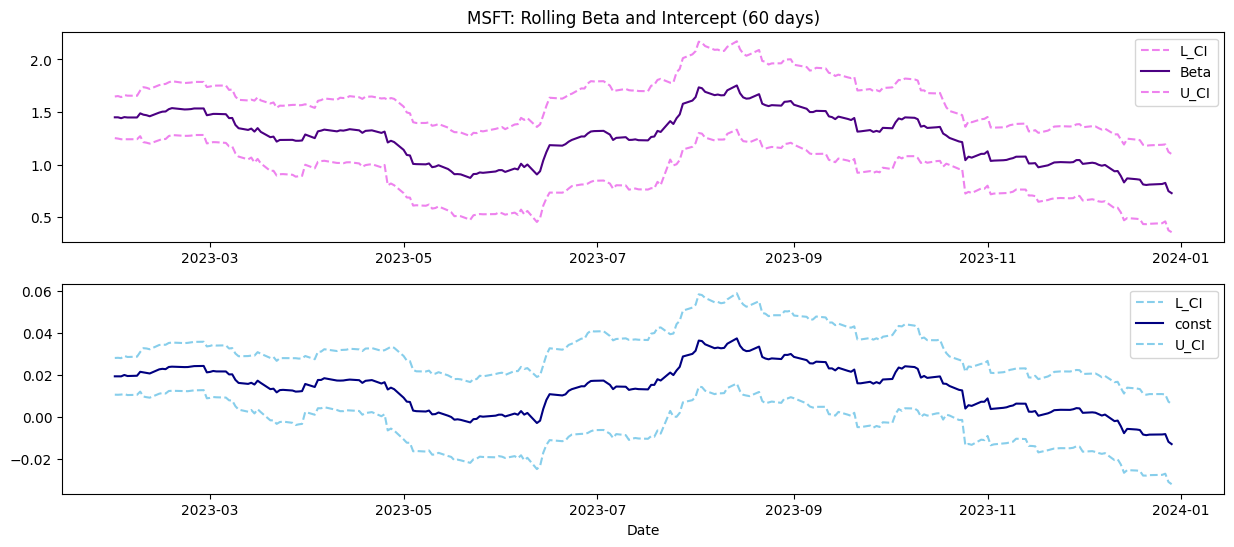

In [18]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, figsize = (15, 6)) #indicate that there are two subplots
ax[0].plot(Parameters['Date'], Parameters['Beta_Lower'], label  = 'L_CI', color = 'violet', linestyle = '--')
ax[0].plot(Parameters['Date'], Parameters['Beta'], label  = 'Beta', color = 'indigo')
ax[0].plot(Parameters['Date'], Parameters['Beta_Upper'], label  = 'U_CI', color = 'violet', linestyle = '--')
ax[0].legend(loc = 1)
ax[1].set_xlabel('Date', fontsize  = 10)
ax[0].set_title('MSFT: Rolling Beta and Intercept (60 days)')
ax[1].plot(Parameters['Date'], Parameters['const_lower'], label  = 'L_CI', color = 'skyblue', linestyle = '--')
ax[1].plot(Parameters['Date'], Parameters['const'], label  = 'const', color = 'navy')
ax[1].plot(Parameters['Date'], Parameters['const_upper'], label  = 'U_CI', color = 'skyblue', linestyle = '--')
ax[1].legend(loc = 1)
plt.savefig('MSFT_CAPM_Rolling.png')

## Simulating CAPM over Multiple Stocks

In [19]:
#restart kernel

import yfinance as yf
import pandas as pd 
import matplotlib.pyplot as plt #library for plotting


SDate = '2022-11-01'
EDate = '2023-12-31'

def CAPM_Data(Ticker, Sdate, Edate):
    tick = yf.Ticker(Ticker)
    hist_data =  tick.history(start = Sdate, end = Edate)
    hist_data['Returns'] = hist_data['Close'].pct_change()
    hist_data = hist_data[hist_data['Returns'].notna()]
    hist_data.reset_index(inplace = True)
    hist_data.rename(columns = {'index':'Date'}, inplace = True)
    hist_data['Date'] = hist_data['Date'].dt.strftime('%Y/%m/%d')
    hist_data['Date'] = pd.to_datetime(hist_data['Date']) 
    hist_data = hist_data[['Date', 'Close', 'Returns']]
    hist_data.rename(columns = {'Close': Ticker + '_Close', 'Returns': Ticker + '_Returns'}, inplace = True)
    return hist_data


Creating a CAPM dataset for Multiple Stocks

In [20]:
Tick = ['MSFT', 'AAPL', 'AMZN', 'NVDA' , 'META', 'AMD']
Data = []
for i in range(len(Tick)):Data.append(CAPM_Data(Tick[i], SDate, EDate))
Stock_Data = pd.concat(Data, axis = 1)
Stock_Data.drop('Date', inplace = True, axis = 1)


Market = CAPM_Data('^GSPC', SDate, EDate)   #S&P 500 
Market.drop('Date', inplace = True, axis = 1)

TBills = CAPM_Data('^IRX', SDate, EDate)   #3-month t-bills
TBills['Rate'] = TBills['^IRX_Close']/100
TBills = TBills[['Date', 'Rate']]
CAPM = pd.concat([Stock_Data, Market, TBills], axis = 1)
CAPM['Rm-Rf'] = CAPM['^GSPC_Returns'] - CAPM['Rate'] #Excess Market Returns

for i in range(len(Tick)): CAPM['R_' + Tick[i] + '-Rf'] = CAPM[Tick[i] +'_Returns'] - CAPM['Rate']

CAPM.to_excel('CAPM_Multiple_Stocks.xlsx')
CAPM = pd.read_excel('CAPM_Multiple_Stocks.xlsx')

Computing and Plotting Rolling Beta

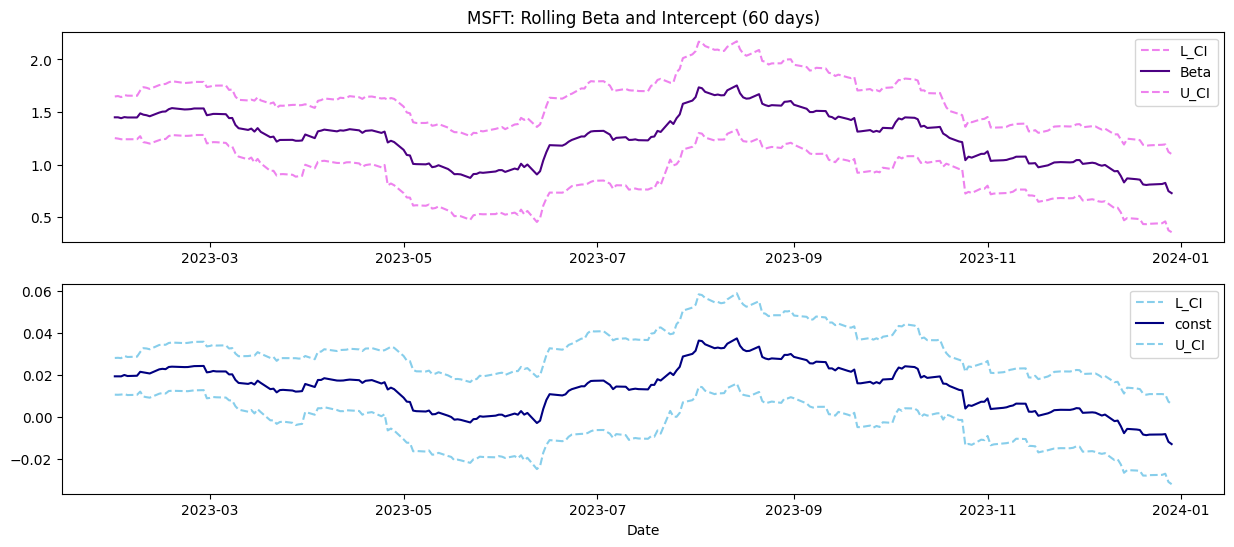

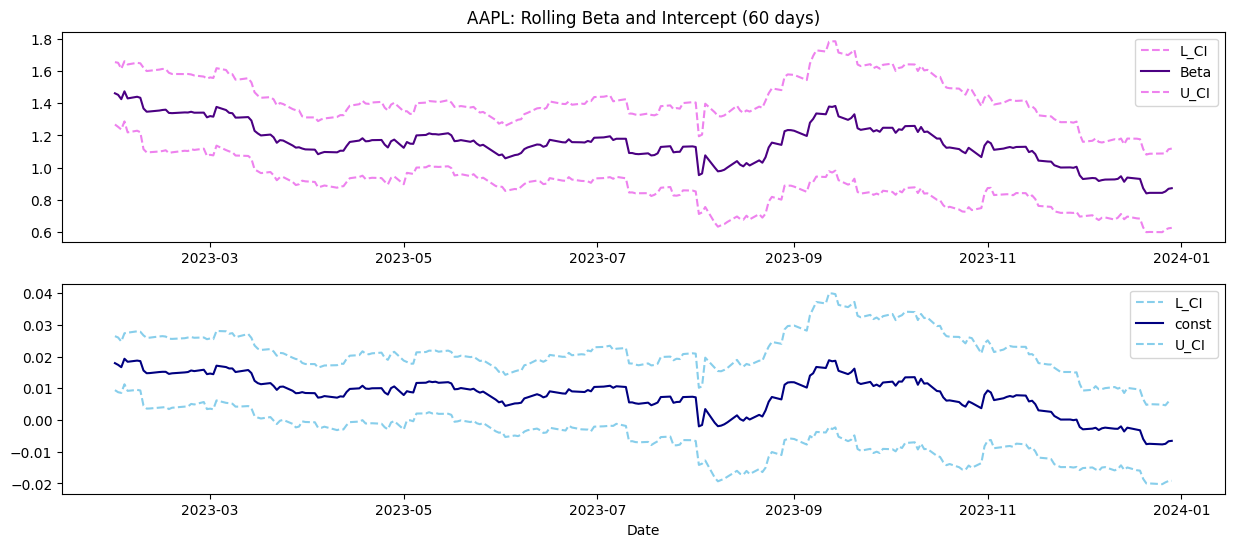

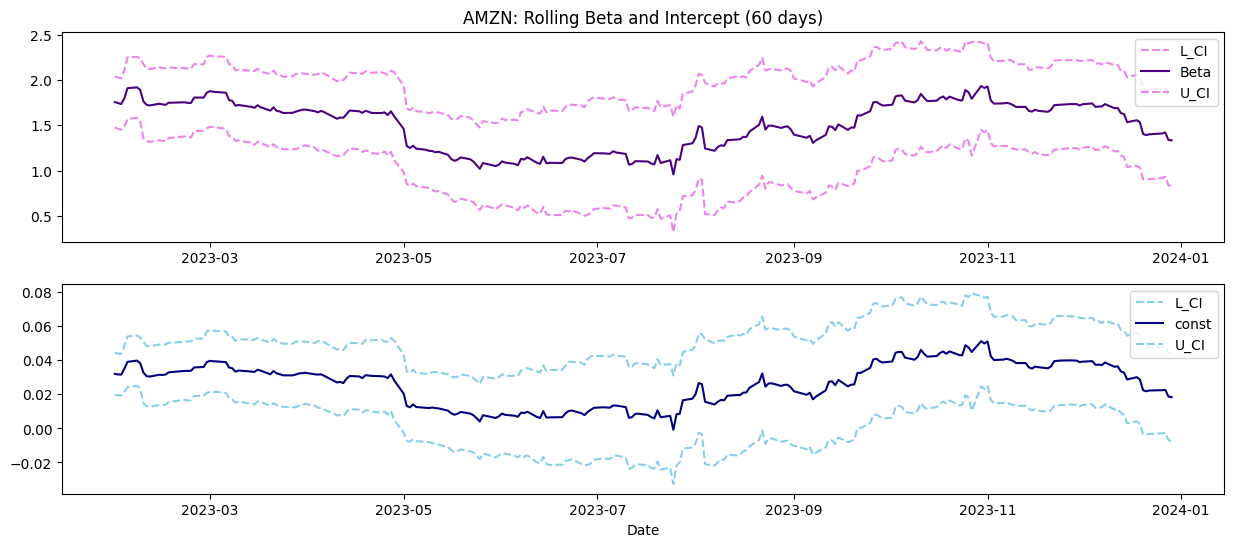

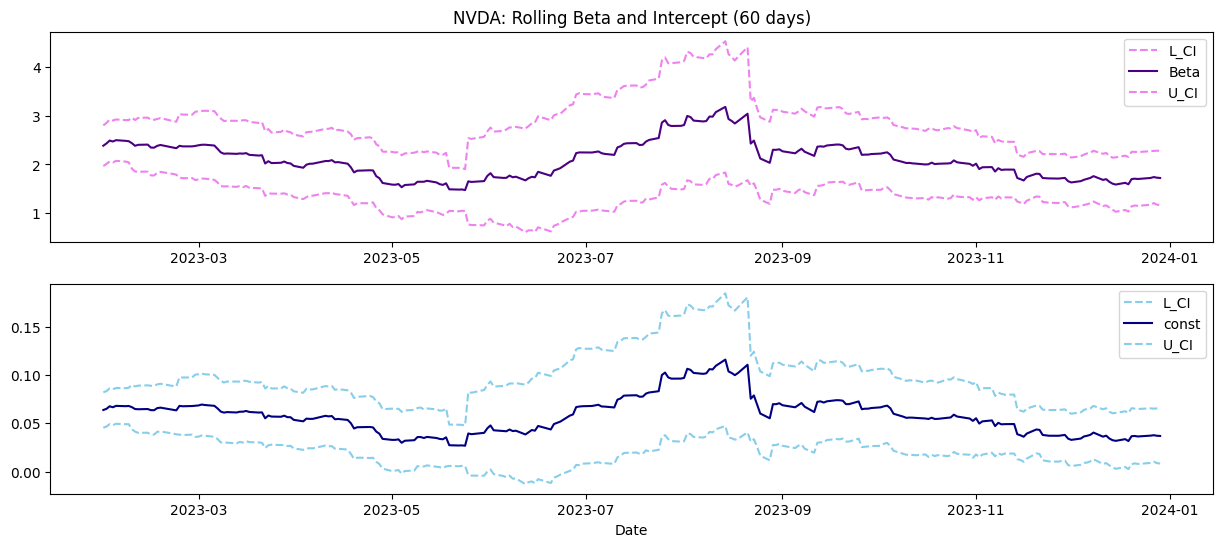

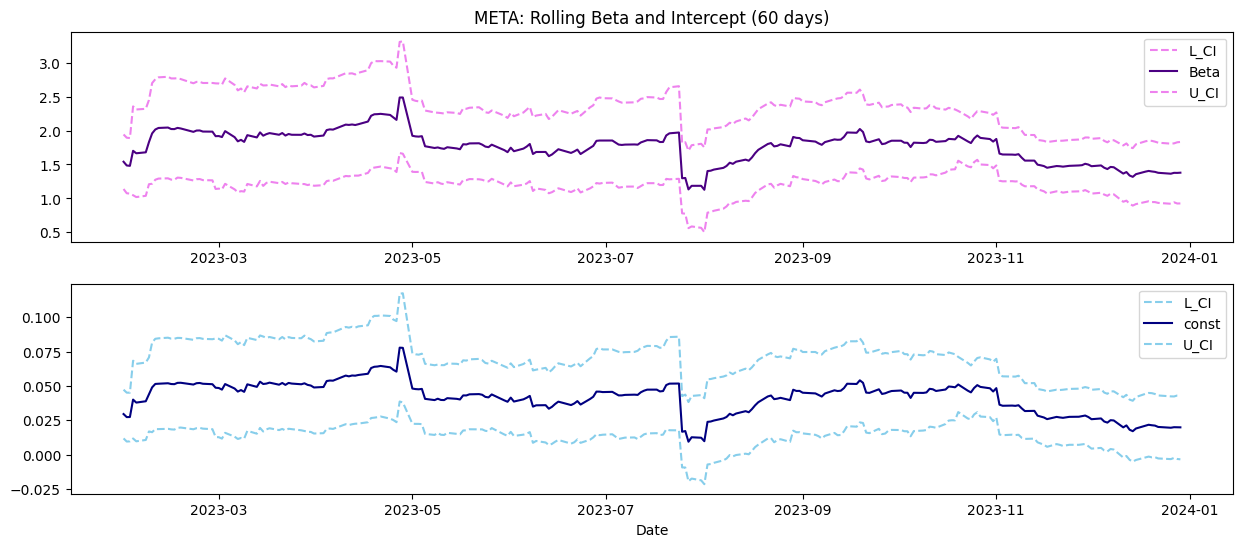

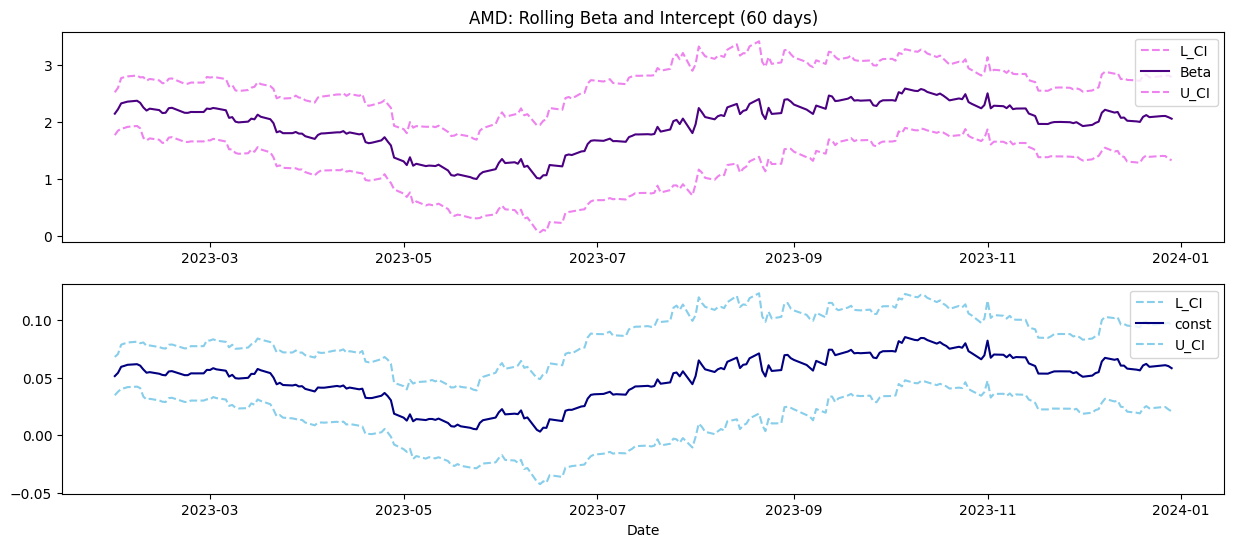

In [21]:
import statsmodels.api as sm 
from statsmodels.regression.rolling import RollingOLS

Parameters_Append = []
Summary_Statistics = []
for i in range(len(Tick)): 
    Y = CAPM['R_' + Tick[i] + '-Rf'] 
    X = CAPM['Rm-Rf']
    X = sm.add_constant(X)
    mod = RollingOLS(Y, X, window = 60)  #60-day window
    rolling_reg = mod.fit()
    params  = rolling_reg.params.copy() #Copies parameters to DataFrame
    conf_int = rolling_reg.conf_int(alpha = 0.05)  
    Parameters = pd.concat([params, conf_int], axis = 1)
    Parameters.columns #Check Column names
    Parameters.rename(columns = {'const': Tick[i] + '_const', 'Rm-Rf':Tick[i] + '_Beta', ('const', 'lower'):Tick[i] + '_const_lower',('const', 'upper'): Tick[i] + '_const_upper',('Rm-Rf', 'lower'):Tick[i] + '_Beta_Lower', ('Rm-Rf', 'upper'):Tick[i] + '_Beta_Upper'}, inplace = True)
    Parameters['Date'] = CAPM['Date']
    Parameters_Append.append(Parameters)
    Summary_Statistics.append(Parameters.describe()) #Automatically does not consider nan 
    
    fig, ax = plt.subplots(2, figsize = (15, 6)) #indicate that there are two subplots
    ax[0].plot(Parameters['Date'], Parameters[Tick[i] + '_Beta_Lower'], label  = 'L_CI', color = 'violet', linestyle = '--')
    ax[0].plot(Parameters['Date'], Parameters[Tick[i] + '_Beta'], label  = 'Beta', color = 'indigo')
    ax[0].plot(Parameters['Date'], Parameters[Tick[i] + '_Beta_Upper'], label  = 'U_CI', color = 'violet', linestyle = '--')
    ax[0].legend(loc = 1)
    ax[1].set_xlabel('Date', fontsize  = 10)
    ax[0].set_title(Tick[i] + ': Rolling Beta and Intercept (60 days)')
    ax[1].plot(Parameters['Date'], Parameters[Tick[i] + '_const_lower'], label  = 'L_CI', color = 'skyblue', linestyle = '--')
    ax[1].plot(Parameters['Date'], Parameters[Tick[i] + '_const'], label  = 'const', color = 'navy')
    ax[1].plot(Parameters['Date'], Parameters[Tick[i] + '_const_upper'], label  = 'U_CI', color = 'skyblue', linestyle = '--')
    ax[1].legend(loc = 1)
    plt.savefig(Tick[i] + '_CAPM_Rolling.png')

Parameters_Stocks = pd.concat(Parameters_Append, axis = 1)
Summary_Statistics_Rolling = pd.concat(Summary_Statistics, axis = 1)

Plotting Rolling Betas on the same graph.

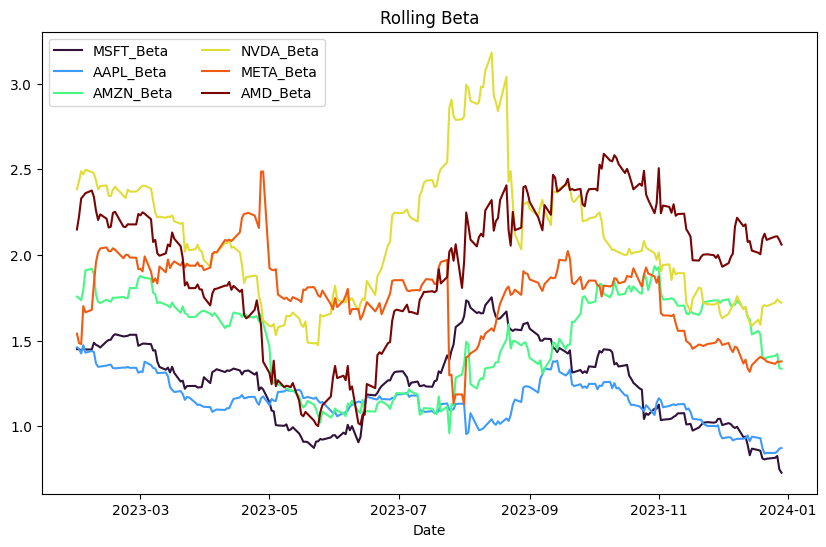

In [22]:

import numpy as np 

#Define Figure before Loop to ensure a single plot. 
plt.figure(figsize = (10, 6))   

color = iter(plt.cm.turbo(np.linspace(0,1,len(Tick))))  
#colors are iterated (using np.linspace) over range of 0 and 1, using the number of Ticks (6) as iterations.
#For more colors: https://matplotlib.org/stable/users/explain/colors/colormaps.html
#plt.cm.turbo: turbo is the color type (calling colormaps, cm, from plt).
    
for i in range(len(Tick)): 
    Y = CAPM['R_' + Tick[i] + '-Rf'] 
    X = CAPM['Rm-Rf']
    X = sm.add_constant(X)
    mod = RollingOLS(Y, X, window = 60)  #60-day window
    rolling_reg = mod.fit()
    params  = rolling_reg.params.copy() #Copies parameters to DataFrame
    conf_int = rolling_reg.conf_int(alpha = 0.05)  
    Parameters = pd.concat([params, conf_int], axis = 1)  #params are concated to each column.
    Parameters.columns #Check Column names
    Parameters.rename(columns = {'const': Tick[i] + '_const', 'Rm-Rf':Tick[i] + '_Beta', ('const', 'lower'):Tick[i] + '_const_lower',('const', 'upper'): Tick[i] + '_const_upper',('Rm-Rf', 'lower'):Tick[i] + '_Beta_Lower', ('Rm-Rf', 'upper'):Tick[i] + '_Beta_Upper'}, inplace = True)
    Parameters['Date'] = CAPM['Date']
    c = next(color) #next color with each loop 
    plt.plot(Parameters['Date'], Parameters[Tick[i] + '_Beta'], label  = Tick[i] + '_Beta',  color=c)
    plt.xlabel('Date', fontsize = 10)
    plt.title('Rolling Beta')
    plt.legend(loc = 2, ncol = 2)  #ncol = 2, splits legend into 2 columns.
    plt.savefig('Rolling_Beta.png')